# NB5 River network and property analysis

Use 
1. flowline geopackage
2. augmented river network netCDF 
3. seasonal flow netCDF

[1. How many lakes in upstream](#count_lakes)

[2. Compute channel properties](#compute_channel_property)

[3. Plot channel properties](#plot_channel_property)

In [1]:
%matplotlib inline

import os, sys
import time
import tomli
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

from scripts.utility import load_toml
from scripts.utility import read_shps
from scripts.utility import get_index_array

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(np.__name__, np.__version__)
print(gpd.__name__, gpd.__version__)
print(pd.__name__, pd.__version__)


The Python version: 3.10.12
xarray 2023.6.0
numpy 1.24.4
geopandas 0.13.2
pandas 2.0.3


In [3]:
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
land = cfeature.LAND
stamen_terrain = cimgt.Stamen('terrain-background')

-------------------------
## Please provide CESM case name and ROF grid name

In [4]:
# CESM case names and their runoff grid
cases = {
        #'f09_f09_rHDMA':'rHDMA',
        #'f09_f09_rHDMAlk_mg17':'rHDMAlk',
        'f09_f09_rMERIT_mg17':'rMERIT',
        #'f09_f09_mg17_mosart':'mosart',
        }

save_modified_geom = True

-------------------------
## 1. Setup
load config files and some parameters 

In [5]:
setup = load_toml('./setup/setup.toml')

# directories
main_dir       = setup['archive_dir']    # ctsm archive top directory
domain_dir     = setup['ancillary_dir']  # domain directory
geospatial_dir = setup['geospatial_dir'] # gpkg directory
ancillary_dir  = setup['ancillary_dir']  # misclineous directory
ref_flow_dir   = setup['ref_flow_dir']   # reference flow directory

# data meta
rof_grid = setup['rof_grid']             # ROF grid meta
reach_gpkg = setup['reach_gpkg']         # reach gpkg meta
catch_gpkg = setup['catch_gpkg']         # catchment gpkg meta
network = setup['river_network']         # river network data meta

---
## 2. Loading data <a id='load_flow_data2'></a>

### 2.1. Read river network data
- ds_network (xr dataset) including all the data
- riv_network (dataframe) including reach properties

In [6]:
reach_variables =['Length','Slope','man_n','totalArea','streamOrder','Tosegment', 'width', 'depth']
riv_network = {}
ds_network  = {}
ds_network_mod = {}
reachID_list = {}
for case, grid_name in cases.items():
    domain   = rof_grid[grid_name]['domain_nc']
    network_name = rof_grid[grid_name]['network']
    seg_id_name  = network[network_name]['reach_ID']
    
    reach_variables.append(seg_id_name)
    
    network_file = os.path.join(ancillary_dir, network[network_name]['file_name'])  # geopackage name
    print(f"reading {network_file}...")
    ds_network[case] = xr.open_dataset(network_file)#.set_index(seg='seg_id')
    ds_network[case][seg_id_name] = ds_network[case][seg_id_name].astype('int')
    
    reachID_list[case] = ds_network[case][seg_id_name].astype('int').values

    riv_network[case] = ds_network[case][reach_variables].to_dataframe()
    
    if domain=='None':  # domain = None (not string) -> mizuRoute
        ds_network_mod[case] = ds_network[case][reach_variables]

reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/scripts/ancillary_data/ntopo_MERIT_Hydro_v1.aug.nc...


### 2.1.  Read climatological monthly flow netCDFs

month_max_flow (xarray dataArray)

In [7]:
%%time

month_max_flow  = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, 'rof/hist')
    model    = rof_grid[grid_name]['model']
    domain   = rof_grid[grid_name]['domain_nc']
    flow_var = rof_grid[grid_name]['flow_name']
    
    #seasonal
    seas_data = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.seasonal.nc', data_vars='minimal')
    month_max_flow[case] = seas_data[flow_var].max(dim='month').load()
    
    if domain=='None':  # domain = None (not string) -> mizuRoute
        ix_sorted = get_index_array(seas_data['reachID'].values.astype('int32'), reachID_list[case])
        month_max_flow[case] = month_max_flow[case].isel(dict(seg=ix_sorted))

CPU times: user 511 ms, sys: 203 ms, total: 714 ms
Wall time: 2.48 s


### 2.3. Read reach-D19 gauge link csv

In [8]:
gauge_reach_lnk = {}
for case, grid_name in cases.items():
    gauge_reach_lnk[case] = pd.read_csv('%s/D09_925.%s.asc'%(ref_flow_dir, rof_grid[grid_name]['network']))

### 2.4. Read D19 flow site shapefile

In [9]:
gauge_shp = gpd.read_file(os.path.join(ref_flow_dir, 'geospatial','D09_925.shp'))
gauge_shp = gauge_shp[gauge_shp['id']!=9999999]

### 2.5. Read global river reach geopackage
- global_river (dataframe)

In [10]:
%%time
## river
global_river = {}
for case, grid_name in cases.items():
    
    network_name = rof_grid[grid_name]['network']
    
    riv_gpkg = os.path.join(geospatial_dir, reach_gpkg[network_name]['file_name'])  # geopackage name
    id_name_river = reach_gpkg[network_name]['id_name']                               # reach ID in geopackage
    downid_name = reach_gpkg[network_name]['down_id_name']                          # downstream reach ID in geopackage
    global_river[network_name] = read_shps([riv_gpkg], [id_name_river, downid_name])
    global_river[network_name] = global_river[network_name].astype({id_name_river:'int64', downid_name:'int64'})

Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/rivEndMERIT_simplified_0003.gpkg
CPU times: user 3min 53s, sys: 3.32 s, total: 3min 57s
Wall time: 4min 11s


### 2.6. Read large river ID and name
- big_river_50 (dictionary {_site_id_:_river name_})
- big_river_24 (dictionary {_site_id_:_river name_})

In [11]:
df = pd.read_csv('./setup/large_river_50.txt', index_col='river_name')
big_river_50 = {key: values['site_id'] for key, values in df.iterrows()}
big_river_24 = {key: values['site_id'] for ix, (key, values) in enumerate(df.iterrows()) if ix<24} # The first 24 is used for plots

### Get indices in obs and sim data for gauge name
- gauge_plot (dictionary)

In [11]:
gauge_plot = {}
for site_name, site_id in big_river_50.items():
    gauge_plot[site_name] = {}
    for case, _ in cases.items():
        df_g = gauge_reach_lnk[case]
        seg_id = df_g.loc[df_g['gauge_id']==site_id]['route_id'].values
        seg_ix = np.argwhere(reachID_list[case]==seg_id)   # matching reach ix in river network
        gauge_plot[site_name][case] = [seg_ix[0], seg_id]

---
## 1. How many lakes are in upstreams? <a id='count_lakes'></a>
- applicable for only **rHDMAlk**

In [12]:
case = 'f09_f09_rHDMAlk_mg17'

lake_storage = {}
print("river n_lakes total_vol[m3]")

grid_name = cases[case]
        
for site_name, site_id in big_river_50.items():
 
    seg_id = gauge_plot[site_name][case][1]
    seg_ix = gauge_plot[site_name][case][0]
    
    ix1 = int(ds_network[case]['upAll_start'].values[seg_ix])
    nUp = int(ds_network[case]['upAll_count'].values[seg_ix])
    
    ix_ups = ds_network[case]['allUpSegIndices'].values[ix1-1:ix1+nUp].astype(int)
    ix_lakes = np.where(ds_network[case]['lake'].values[ix_ups]==1)[0]
    num_lakes  = np.count_nonzero((ds_network[case]['lake'].values[ix_ups] == 1))
    lake_storage[site_name] = np.sum(ds_network[case]['S_max'].values[ix_lakes])
        
    print("{0:>20} {1:>3d} {2:>15.2f}".format(site_name, num_lakes, lake_storage[site_name]))


river n_lakes total_vol[m3]
              Amazon  60  85301957875.34
               Congo  33  48524145169.94
             Orinoco   6   7604901684.34
          Changjiang  62  80935006576.27
         Brahmaputra   8  10253721041.73
         Mississippi 127 172993303483.43
             Yenisey  17  23057896156.62
              Parana  74  99384879724.11
                Lena  10  13098675554.55
              Mekong  10  12604303735.71
           Tocantins   9  11555528604.94
                  Ob 125 174453884061.92
              Ganges  17  22037660885.09
           Irrawaddy   3   3756304814.18
         St Lawrence  34  43539453031.43
                Amur  41  53499054865.69
           Mackenzie 113 149481232627.15
             Xijiang  10  12042610013.53
            Columbia  34  43451824760.88
           Magdalena  12  15054915088.39
             Uruguay   3   3786410332.86
               Yukon  25  32575678967.95
              Danube  20  25622544317.29
               Niger  26  339

---
### 2. Compute channel properties <a id='compute_channel_property'></a>
- applicable for only **rHDMAlk** or **rHDMA**

In [12]:
cases

{'f09_f09_rMERIT_mg17': 'rMERIT'}

### 2.1 Channel width <a id='compute_width'></a>

In [13]:
case = 'f09_f09_rMERIT_mg17'

network_name = rof_grid[cases[case]]['network']

nseg = len(ds_network_mod[case].seg)
width = np.full((nseg,2), 0.0)
width[:,0] = 0.0010*(ds_network_mod[case]['totalArea'].values)**0.5
width[:,1] = 1.2*month_max_flow[case].values**0.7

# set minimum width to 10 meter
width = np.where(width>10.0, width, 10.0) 

ds_network_mod[case]['width'].values = width[:,1]
riv_network[case]['width_mod_maxflow'] = width[:,1]

In [13]:
for ix in np.arange(2):
    print("{0} {1: 6.2f} {2: 6.2f} {3: 6.2f}".format(ix, np.min(width[:,ix],axis=0), np.median(width[:,ix],axis=0), np.max(width[:,ix],axis=0)))

0  10.00  10.08  2430.01
1  10.00  10.00  7359.12


### 2.2 Channel bankful depth <a id='compute_depth'></a>

In [14]:
case = 'f09_f09_rMERIT_mg17'

network_name = rof_grid[cases[case]]['network']

nseg = len(ds_network_mod[case].seg)
depth = np.full((nseg,3), 0.0)
depth[:,0] = 0.030*month_max_flow[case].values**0.65 #just test
depth[:,1] = 0.035*month_max_flow[case].values**0.65 
depth[:,2] = 0.000045*(ds_network_mod[case]['totalArea'].values)**0.5

# set minimum depth to 1 meter
depth = np.where(depth>1.0, depth, 1.0)

ds_network_mod[case]['depth'].values = depth[:,1]
riv_network[case]['depth_mod_maxflow'] = depth[:,1]
riv_network[case]['depth_mod_area'] = depth[:,2]

In [15]:
for ix in np.arange(3):
    print("{0} {1: 6.2f} {2: 6.2f} {3: 6.2f}".format(ix, np.min(depth[:,ix],axis=0), np.median(depth[:,ix],axis=0), np.max(depth[:,ix],axis=0)))

0   1.00   1.00  98.68
1   1.00   1.00  115.12
2   1.00   1.00  109.35


### 2.3. Output modified river geometry

In [16]:
if save_modified_geom:
    network_name = rof_grid[cases[case]]['network']
    network_file = os.path.join(ancillary_dir, network[network_name]['file_name'])  # geopackage name
    ds_network_mod[case][['seg_id','depth','width']].to_netcdf(network_file.replace('aug.nc','mod.nc'))

## 3. River geometry evaluation <a id='plot_channel_property'></a>
- map
- cdf

In [15]:
# create colormaps
# ---------------
#cmap = mpl.cm.turbo_r(np.arange(256))

cmap1 = mpl.cm.Spectral_r(np.arange(256))
# convert to matplotlib colormap
cmap1 = mpl.colors.ListedColormap(cmap1, name='myColorMap', N=cmap1.shape[0])#cmap.shape[0]
cmap1.set_under('xkcd:light grey')

cmap2 = mpl.cm.plasma_r(np.arange(256))
# convert to matplotlib colormap
cmap2 = mpl.colors.ListedColormap(cmap2, name='myColorMap', N=cmap2.shape[0])
cmap2.set_under('xkcd:light grey')

cmap3 = mpl.cm.plasma(np.arange(256))
# convert to matplotlib colormap
cmap3 = mpl.colors.ListedColormap(cmap3, name='myColorMap', N=cmap3.shape[0])
cmap3.set_under('xkcd:light grey')

In [16]:
# some local plot setups
cm = {
      'Slope':      cmap1,
      'man_n':      cmap3,
      'width':      cmap1,
      'depth':      cmap2,
      'width_mod_maxflow':  cmap1,
      'depth_mod_area':  cmap2,
      'depth_mod_maxflow':  cmap2,
     }

unit = {'Slope':'-',
        'man_n':'-',
        'width':'m',
        'depth':'m',
        'width_mod_maxflow':'m',
        'depth_mod_area':'m',
        'depth_mod_maxflow':'m',
       }

meta = {
        'Slope':             {'vmin':0,    'vmax':0.005, 'cm':cm['Slope'],     'norm':'linear'},
        'man_n':             {'vmin':0.01, 'vmax':0.05,  'cm':cm['man_n'],     'norm':'linear'},
        'width':             {'vmin':10,   'vmax':4000,  'cm':cm['width'],     'norm':'log'},
        'depth':             {'vmin':2,    'vmax':100,   'cm':cm['depth'],     'norm':'log'},
        'width_mod_maxflow': {'vmin':10,   'vmax':4000,  'cm':cm['width_mod_maxflow'], 'norm':'log'},
        'depth_mod_area':    {'vmin':2,    'vmax':100,   'cm':cm['depth_mod_area'], 'norm':'log'},
        'depth_mod_maxflow': {'vmin':2,    'vmax':100,   'cm':cm['depth_mod_maxflow'], 'norm':'log'},
        } 

cbar_kwrgs = {"shrink":0.8, "pad":0.055, "orientation": "horizontal", 'extend':'both'}


In [17]:
cases

{'f09_f09_rMERIT_mg17': 'rMERIT'}

CPU times: user 30.8 s, sys: 418 ms, total: 31.2 s
Wall time: 34.1 s


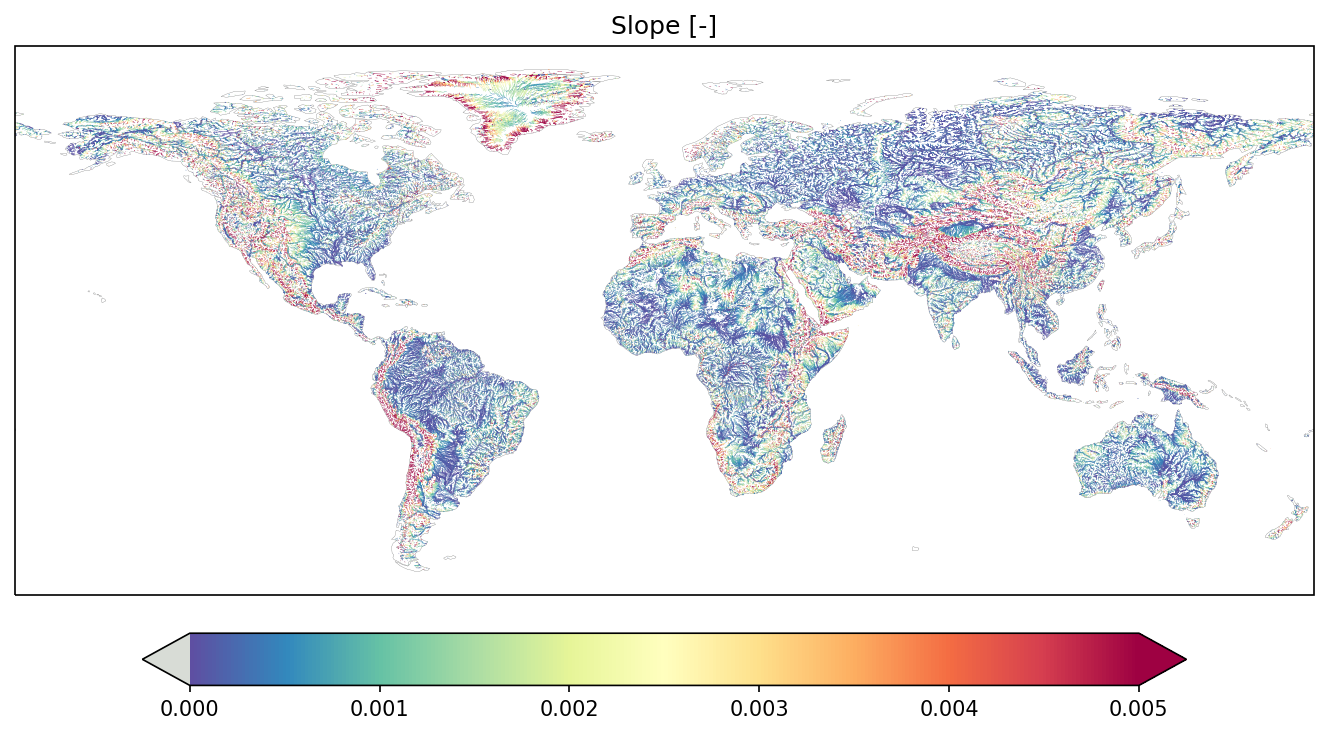

In [27]:
%%time

plot_case = 'f09_f09_rMERIT_mg17'
network_name = rof_grid[cases[plot_case]]['network']

param = 'Slope'

fig = plt.figure(figsize=(9.0, 5.0), dpi=150)
ax  = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.add_feature(land, facecolor='xkcd:white', lw=0.1, edgecolor='xkcd:dark grey')

df_reach_aug = pd.merge(global_river[network_name], riv_network[plot_case], left_on=reach_gpkg[network_name]['id_name'], right_on='seg_id')

lw=0.3
if plot_case=='f09_f09_rMERIT_mg17':
    df_reach_aug = df_reach_aug[df_reach_aug['streamOrder']>2]

if meta[param]['norm']=='log':
    norm = mpl.colors.LogNorm(vmin=meta[param]['vmin'], vmax=meta[param]['vmax'])
elif meta[param]['norm']=='linear':
    norm = mpl.colors.Normalize(vmin=meta[param]['vmin'], vmax=meta[param]['vmax'])

df_reach_aug[df_reach_aug['streamOrder']==3].plot(ax=ax, column=param, lw=lw-0.1, cmap=meta[param]['cm'], norm=norm, zorder=1)
df_reach_aug[df_reach_aug['streamOrder']==4].plot(ax=ax, column=param, lw=lw,     cmap=meta[param]['cm'], norm=norm, zorder=2)
df_reach_aug[df_reach_aug['streamOrder']==5].plot(ax=ax, column=param, lw=lw+0.1, cmap=meta[param]['cm'], norm=norm, zorder=3)
df_reach_aug[df_reach_aug['streamOrder']>=6].plot(ax=ax, column=param, lw=lw+0.2, cmap=meta[param]['cm'], norm=norm, zorder=3)

ax.set_title(f'{param} [{unit[param]}]')
ax.set_xlim(-180, 180)
#ax.set_ylim(-90, 90)

points = ax.collections[0]
plt.colorbar(points, ax=ax, **cbar_kwrgs);

fig.tight_layout()
plt.savefig(f"./NB5_{network_name}_{param}.png", dpi=150)

In [ ]:
fig = plt.figure(figsize=(9.0, 5.0), dpi=200)
ax  = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
norm = mpl.colors.LogNorm(vmin=df_reach_aug['totalArea'].min(), vmax=df_reach_aug['totalArea'].max())
df_reach_aug.plot(ax=ax, column='totalArea', lw=0.3, cmap=meta[param]['cm'], norm=norm)

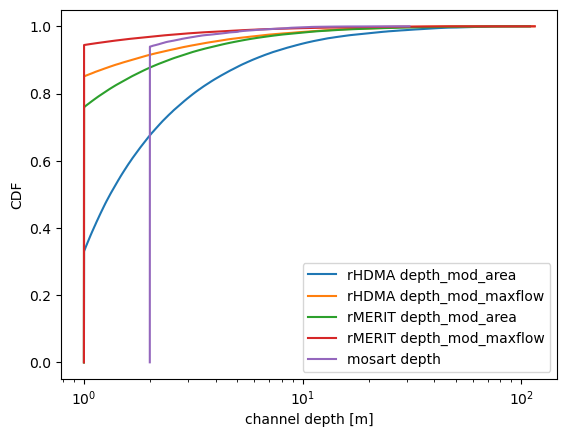

In [34]:
# depth
var_min = 0
var_max = 120

plot_cases = {
              'f09_f09_rHDMA':      ['depth_mod_area', 'depth_mod_maxflow'],
              'f09_f09_rMERIT_mg17':['depth_mod_area', 'depth_mod_maxflow'],  
              'f09_f09_mg17_mosart':['depth'],
             }

for case, var_list in plot_cases.items():
    
    for var in var_list:
        if case=='f09_f09_mg17_mosart':
            mask = (riv_network[case][var]>var_min) & (riv_network[case][var]<var_max) & (riv_network[case]['seg_id']>=46389) # remove antarctica
        else:
            mask = (riv_network[case][var]>var_min) & (riv_network[case][var]<var_max)
    
        nseg = np.count_nonzero(mask)
        value = riv_network[case][var][mask].values
    
        X1 = np.sort(value, axis=0)
        F1 = np.array(np.arange(nseg)/(float(nseg)+1))
        plt.plot(X1, F1, label=f"{cases[case]} {var}");
plt.xscale('log')
plt.xlabel('channel depth [m]')
plt.ylabel('CDF')
plt.legend();
plt.savefig(f"./NB5_depth_cdf.png", dpi=150)

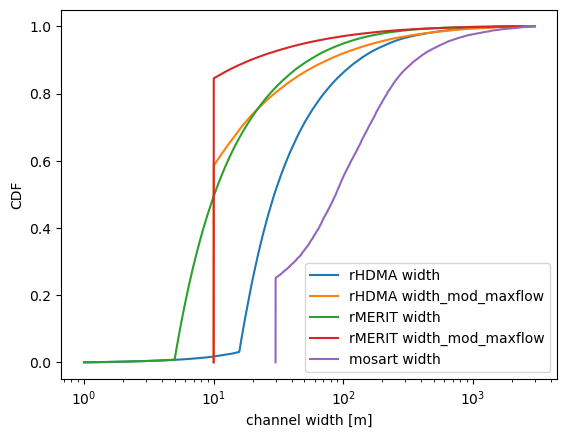

In [35]:
var_min = 1
var_max = 3000

plot_cases = {
              'f09_f09_rHDMA':      ['width','width_mod_maxflow'],
              'f09_f09_rMERIT_mg17':['width','width_mod_maxflow'],
              'f09_f09_mg17_mosart':['width'],
             }

for case, var_list in plot_cases.items():
    
    for var in var_list:
        if case=='f09_f09_mg17_mosart':
            mask = (riv_network[case][var]>var_min) & (riv_network[case][var]<var_max) & (riv_network[case]['seg_id']>=46389) # remove antarctica
        else:
            mask = (riv_network[case][var]>var_min) & (riv_network[case][var]<var_max)
            
        nseg = np.count_nonzero(mask)
        val = riv_network[case][var][mask].values
    
        X1 = np.sort(val, axis=0)
        F1 = np.array(np.arange(nseg)/(float(nseg)+1))
        plt.plot(X1, F1, label=f"{cases[case]} {var}");
plt.xscale('log')
plt.xlabel('channel width [m]')
plt.ylabel('CDF')
plt.legend(loc='best');
plt.savefig(f"./NB5_width_cdf.png", dpi=150)

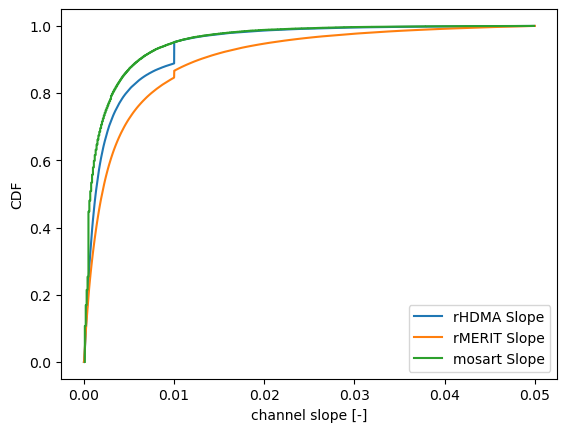

In [36]:
var_min = 0
var_max = 0.05

plot_cases = {
              'f09_f09_rHDMA':      ['Slope'],
              'f09_f09_rMERIT_mg17':      ['Slope'],
              'f09_f09_mg17_mosart':['Slope'],
             }

for case, var_list in plot_cases.items():

    for var in var_list:
        if case=='f09_f09_mg17_mosart':
            mask = (riv_network[case][var]>var_min) & (riv_network[case][var]<var_max) & (riv_network[case]['seg_id']>=46389) # remove antarctica
        else:
            mask = (riv_network[case][var]>var_min) & (riv_network[case][var]<var_max)

        nseg = np.count_nonzero(mask)
        val = riv_network[case][var][mask].values

        X1 = np.sort(val, axis=0)
        F1 = np.array(np.arange(nseg)/(float(nseg)+1))
        plt.plot(X1, F1, label=f"{cases[case]} {var}");
plt.xscale('linear')
plt.xlabel('channel slope [-]')
plt.ylabel('CDF')
plt.legend(loc='best');
plt.savefig(f"./NB5_slope_cdf.png", dpi=150)